Code AAnet cloned from the git https://github.com/KrishnaswamyLab/AAnet/tree/master?tab=readme-ov-file .

In [1]:
import sys, scprep, magic, sklearn
import warnings; warnings.filterwarnings('ignore')
sys.path.append(r'AAnet') # replace with location of AAnet from https://github.com/KrishnaswamyLab/AAnet
import pandas as pd
import tensorflow as tf
import scanpy as sc 
from AAnet_torch import * # use torch implementation
import torch; from torch import optim
import numpy as np
import matplotlib; import matplotlib.pyplot as plt
from sklearn import decomposition
import scipy 

In [2]:
NewsGroups = sc.read(r'datas\9NewsGroups_annData_like.h5ad')

In [18]:
NewsGroups

AnnData object with n_obs × n_vars = 11314 × 1000
    obs: 'n_words', 'percent_stopwords', 'n_chars', 'category'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'category_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

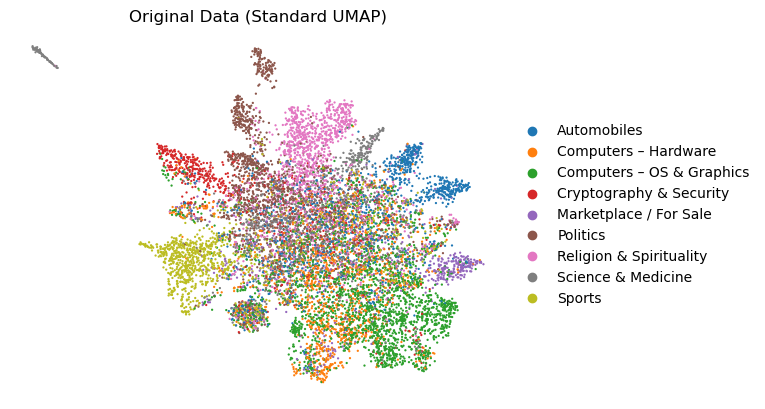

In [102]:
sc.pl.umap(NewsGroups, 
           color='category', 
           title='Original Data (Standard UMAP)',
           frameon=False)

In [4]:
X = NewsGroups.X

if scipy.sparse.issparse(X):
    X = X.toarray()

# 3. Convert to PyTorch Tensor
# We use float32, which is the standard for deep learning models
data_tensor = torch.tensor(X, dtype=torch.float32)

print(f"Data shape ready for AAnet: {data_tensor.shape}")

data_loader = torch.utils.data.DataLoader(X, batch_size=256, shuffle=True, num_workers=2)

Data shape ready for AAnet: torch.Size([11314, 1000])


# Run AAnet_vanilla

The AA vanilla is a determinist one: it doesn't predict mu and sigma for the gaussian distribution of the noise, but instead suppose a gaussian distribution of fixed variance "noise" as an input and mean 0. The loss function is the MSE, thus it shouldn't be working well on our dataset.

In [27]:
N_ARCHETYPES = 4

X = NewsGroups.X

if scipy.sparse.issparse(X):
    X = X.toarray()

extrema = torch.Tensor(utils.get_laplacian_extrema(X, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(X[extrema.numpy().astype(int)])

device = torch.device('cpu')
model_vanilla = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES,
                             input_shape=data_tensor.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer_vanilla = optim.Adam(model_vanilla.parameters(), lr=1e-3)

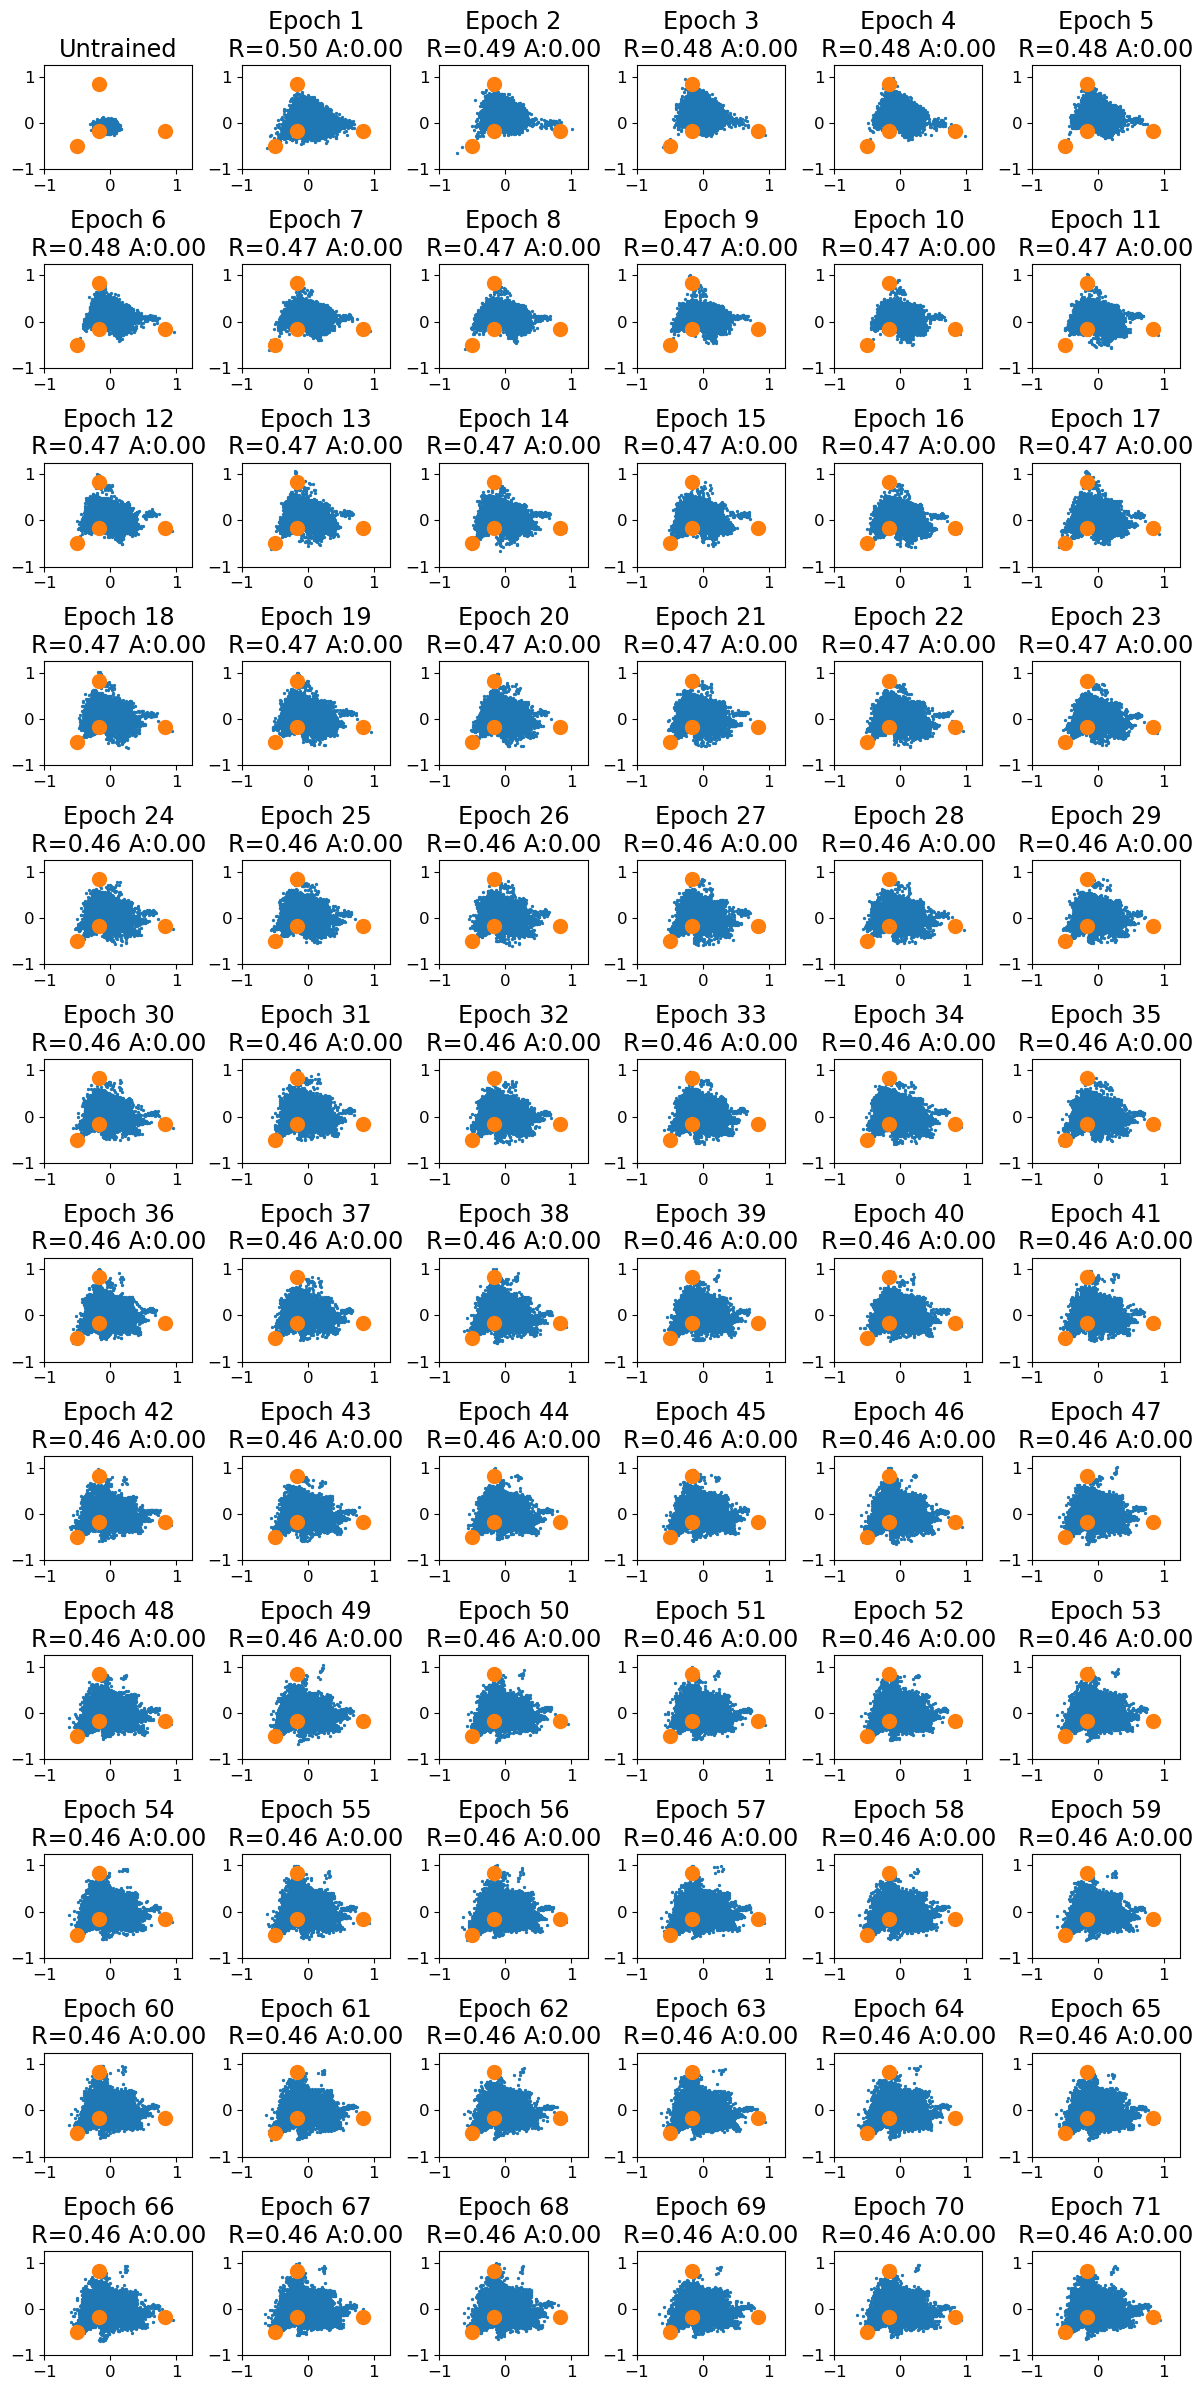

In [28]:
data_loader = torch.utils.data.DataLoader(X, batch_size=256, shuffle=True, num_workers=2)
losses_vanilla = []
epochs = []
reconstruction_losses_vanilla = []
archetypal_losses_vanilla = []

n_row = 12
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        r_loss = a_loss = 0

        title='Untrained'
    else:
        # gamma_extrema parameter weights how informative graph-based extrema are to model
        loss, r_loss, a_loss=utils.train_epoch(model_vanilla, data_loader, optimizer_vanilla, epoch=i, gamma_extrema=1.0)
        title='Epoch {}\nR={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)

    archetypal_embedding = model_vanilla.encode(torch.Tensor(X))

    losses_vanilla.append(loss)
    reconstruction_losses_vanilla.append(r_loss)
    archetypal_losses_vanilla.append(a_loss)
    epochs.append(i)

    scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
    scprep.plot.scatter2d(model_vanilla.get_n_simplex(model_vanilla.n_archetypes).cpu().numpy(), ax=ax)
    ax.set_xlim(-1, 1.25)
    ax.set_ylim(-1, 1.25)

fig.tight_layout()

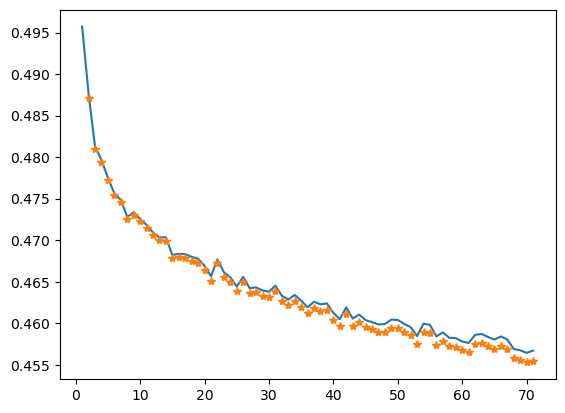

In [ ]:
reconstruction_losses_vanilla = [loss for loss in reconstruction_losses_vanilla]
archetypal_losses_vanilla = [loss for loss in archetypal_losses_vanilla]

plt.plot(epochs[1:],losses_vanilla[1:],'-')
plt.plot(epochs[2:],reconstruction_losses_vanilla[1:],'*')
plt.show()

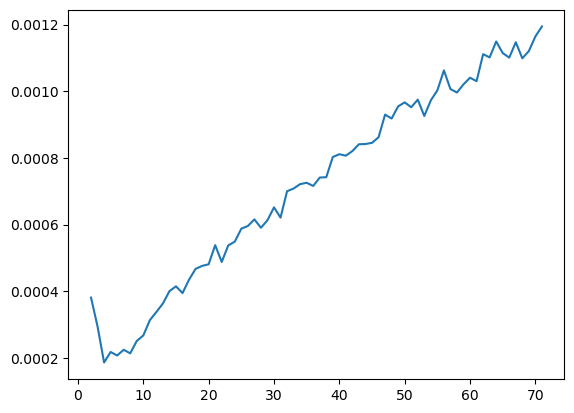

In [56]:
plt.plot(epochs[2:],archetypal_losses_vanilla[1:],'-')
plt.show()

(-1.0225600640599926,
 10.749106023771068,
 -0.8554278338948886,
 10.737747522691887,
 -0.05729166666666667,
 0.05729166666666667)

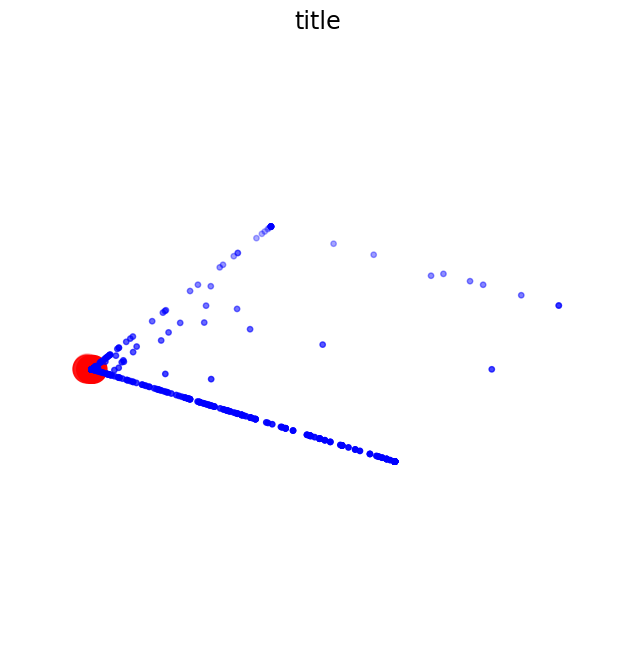

In [ ]:
color = "blue"
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
azim = -30 # for visualization

pc_ats = model_vanilla.decode(model_vanilla.get_n_simplex(model_vanilla.n_archetypes).type(torch.float)).cpu().detach().numpy()

scprep.plot.scatter3d(X, c=color,
                          ylabel=None, zorder=1, s=15,
                          title="title", colorbar=False, ax=ax)

scprep.plot.scatter3d(pc_ats, ax=ax, c='red', s=400, figsize=(10,10), colorbar=False,azim=azim,)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.axis('off')
#for t,coord in enumerate(pc_ats):
#       ax.text(coord[0], coord[1], coord[2], s=t+1, horizontalalignment='center',
#                       verticalalignment='center', fontdict={'color': 'white','size':20,'weight':'bold'}, zorder=4)

## Elbow method

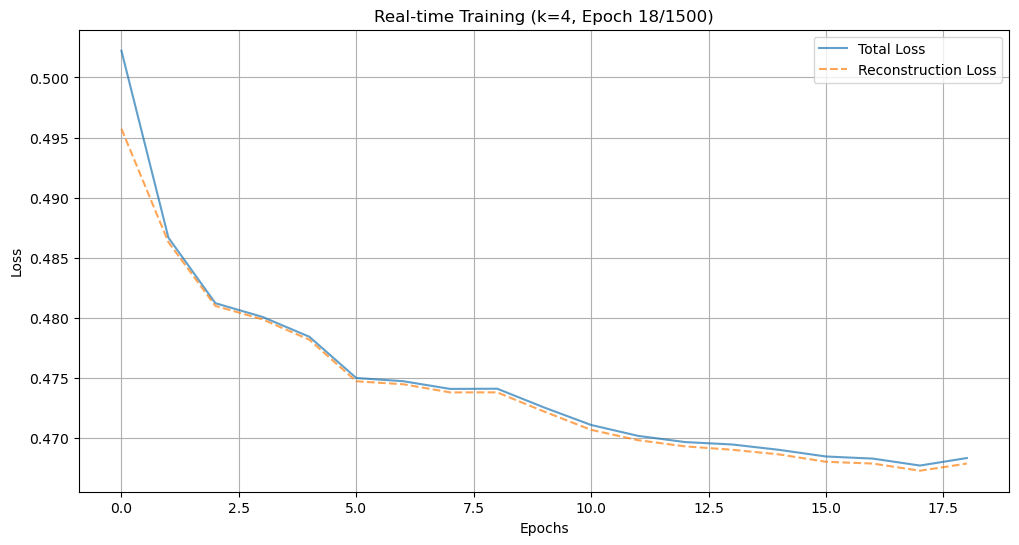

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm 
from IPython.display import clear_output

N_ARCHETYPE = 4
epochs_sweep = 1500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_loader = torch.utils.data.DataLoader(X, batch_size=256, shuffle=True, num_workers=2)

X = NewsGroups.X

if scipy.sparse.issparse(X):
    X = X.toarray()

extrema = torch.Tensor(utils.get_laplacian_extrema(X, n_extrema=N_ARCHETYPE, subsample=False))
extrema = torch.Tensor(X[extrema.numpy().astype(int)])

device = torch.device('cpu')
model_vanilla = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPE,
                             input_shape=data_tensor.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer_vanilla = optim.Adam(model_vanilla.parameters(), lr=1e-3)

losses_vanilla = []
epochs = []
reconstruction_losses_vanilla = []
archetypal_losses_vanilla = []


patience = 50   
min_delta = 1e-4   
best_loss = float('inf')
patience_counter = 0
    
final_epoch_loss = 0
for epoch in tqdm(range(epochs_sweep), desc=f"N_ARCHETYPES={N_ARCHETYPE}", leave=False):
    epoch_loss = 0.0
        
    loss, r_loss, a_loss=utils.train_epoch(model_vanilla, data_loader, 
                                           optimizer_vanilla, epoch=epoch, gamma_extrema=1.0)
        
    #archetypal_embedding_vanilla = model_vanilla.encode(torch.Tensor(X))

    losses_vanilla.append(loss if isinstance(loss, float) else loss.item())
    reconstruction_losses_vanilla.append(r_loss if isinstance(r_loss, float) else r_loss.item())
    archetypal_losses_vanilla.append(a_loss if isinstance(a_loss, float) else a_loss.item())
    epochs.append(epoch)

    if len(epochs) > 1:
        clear_output(wait=True)
        
        plt.figure(figsize=(12, 6))
        
        # Plot Total Loss
        plt.plot(epochs, losses_vanilla, '-', label='Total Loss', alpha=0.7)
        
        # Plot Reconstruction Loss
        plt.plot(epochs, reconstruction_losses_vanilla, '--', label='Reconstruction Loss', alpha=0.7)

        plt.title(f'Real-time Training (k={N_ARCHETYPE}, Epoch {epoch}/{epochs_sweep})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    #Early Stopping
    if r_loss < (best_loss - min_delta):
        best_loss = r_loss
        patience_counter = 0 
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Converged early at epoch {epoch}!")
        break 
    
print("Training Complete.")

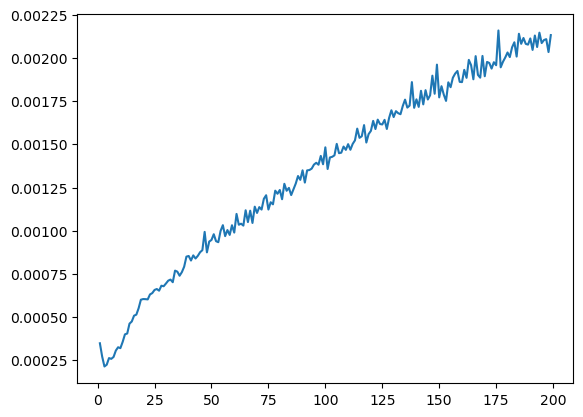

In [40]:
plt.plot(epochs[1:],archetypal_losses_vanilla[1:],'-')
plt.show()

If we don't see any elbow, it can mean that not enough epochs. Thus, lets find untill when does the loss stop decreasing.

In [ ]:
from tqdm import tqdm
k_range = range(2, 12)  
rss_values_vanilla = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = NewsGroups.X

if scipy.sparse.issparse(X):
    X = X.toarray()

print(f"Starting sweep for k = {list(k_range)}...")

for k in k_range:
    print(f"Training for k={k}...")

    extrema = torch.Tensor(utils.get_laplacian_extrema(X, n_extrema=k, subsample=False))
    extrema = torch.Tensor(X[extrema.numpy().astype(int)])

    device = torch.device('cpu')
    model_vanilla = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                                 n_archetypes=k,
                                 input_shape=data_tensor.shape[1],
                                 device=device, diffusion_extrema=extrema)

    optimizer_vanilla = optim.Adam(model_vanilla.parameters(), lr=1e-3)
    
    
    epochs_sweep = 100 
    
    final_epoch_loss = 0
    for epoch in tqdm(range(epochs_sweep), desc=f"k={k}", leave=False):
        epoch_loss = 0.0
        
        loss, r_loss, a_loss=utils.train_epoch(model_vanilla, data_loader, 
                                               optimizer_vanilla, epoch=epoch, gamma_extrema=1.0)
            
        epoch_loss += r_loss.item()
        
        final_epoch_loss = epoch_loss / len(data_loader)
        
    rss_values_vanilla.append(final_epoch_loss)

print("Sweep complete!")



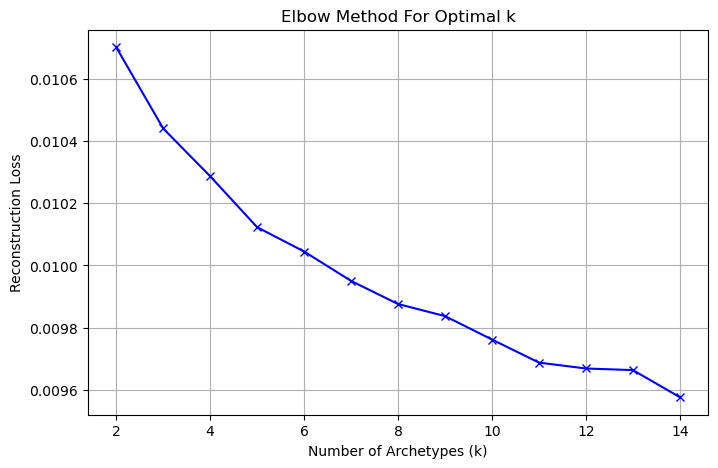

In [107]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, rss_values, 'bx-')
plt.xlabel('Number of Archetypes (k)')
plt.ylabel('Reconstruction Loss')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


# VAE AAnet

Here it's a probabilistic AA network. The gaussian distribution parameters are predicted and we can use different loss functions. We should try with ZIP and ZIBN.

In [5]:
from AAnet_torch.models.AAnet_VAE_diff_losses import AAnet_VAE_diff_losses

In [ ]:
from tqdm import tqdm 
from IPython.display import clear_output

N_range = [2,3,4,5,6,7,8,9,10,11,12]
best_losses = []

for N_ARCHETYPE in N_range:
    epochs_sweep = 1500

    # Setup Extrema
    extrema = torch.Tensor(utils.get_laplacian_extrema(X, n_extrema=N_ARCHETYPE, subsample=False))
    extrema = torch.Tensor(X[extrema.numpy().astype(int)]).float()

    # Setup Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_vae_ZINB = AAnet_VAE_diff_losses(
            input_shape=data_tensor.shape[1],
            n_archetypes=N_ARCHETYPE,       
            layer_widths=[256, 128],
            loss_type="ZINB", 
            device=device, 
            diffusion_extrema=extrema
        )

    optimizer_vae_ZINB = optim.Adam(model_vae_ZINB.parameters(), lr=1e-3)

    losses_vae_ZINB = []
    reconstruction_losses_vae_ZINB = []
    epochs_list = [] 


    patience = 50       
    min_delta = 1e-4    
    best_loss = float('inf')
    patience_counter = 0
        
    for epoch in tqdm(range(epochs_sweep), desc=f"N_ARCHETYPES={N_ARCHETYPE}", leave=False):
        
        model_vae_ZINB.train()
        
        running_loss = 0.0
        running_recon = 0.0
        
        for batch_idx, data in enumerate(data_loader):
            if isinstance(data, list):
                data = data[0]
                
            data = data.to(device).float()
                
            # Forward Pass
            outputs = model_vae_ZINB(data)
                
            # Calculate ZINB Loss
            loss_dict = model_vae_ZINB.loss_function(
                *outputs, 
                M_N=len(data) / len(data_loader.dataset)
            )
                
            loss = loss_dict['loss']
                
            # Backprop
            optimizer_vae_ZINB.zero_grad()
            loss.backward()
            optimizer_vae_ZINB.step()
                
            # Accumulate metrics
            running_loss += loss.item()
            running_recon += loss_dict['Reconstruction_Loss'].item()
            
        # Average metrics for the epoch
        epoch_avg_loss = running_loss / len(data_loader)
        epoch_avg_recon = running_recon / len(data_loader)

        losses_vae_ZINB.append(epoch_avg_loss)
        reconstruction_losses_vae_ZINB.append(epoch_avg_recon)
        epochs_list.append(epoch)

        if epoch_avg_recon < (best_loss - min_delta):
            best_loss = epoch_avg_recon
            patience_counter = 0 
        else:
            patience_counter += 1 
                
        if patience_counter >= patience:
            print(f"Converged early at epoch {epoch}!")
            best_losses.append(best_loss)
            break 
        
    print("Training Complete.")

Converged early at epoch 155!
Training Complete.


Converged early at epoch 166!
Training Complete.


Converged early at epoch 154!
Training Complete.


Converged early at epoch 140!
Training Complete.


Converged early at epoch 139!
Training Complete.


Converged early at epoch 134!
Training Complete.


Converged early at epoch 149!
Training Complete.


Converged early at epoch 140!
Training Complete.


Converged early at epoch 135!
Training Complete.


Converged early at epoch 124!
Training Complete.


Converged early at epoch 154!
Training Complete.


In [14]:
df_best_losses_ZIBN = pd.DataFrame({
    'k': range(2, 2 + len(best_losses)),
    'loss': best_losses
})

df_best_losses_ZIBN.to_csv('best_losses_per_archetype_ZIBN.csv', index=False)

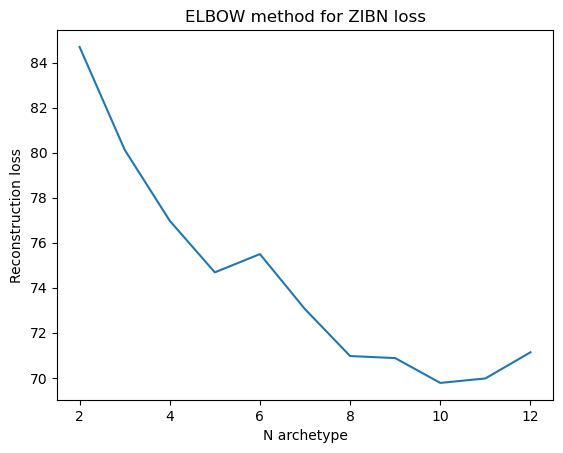

In [17]:
plt.plot(N_range,best_losses,'-')
plt.xlabel("N archetype")
plt.ylabel("Reconstruction loss")
plt.title("ELBOW method for ZIBN loss")
plt.show()

In addition, lets study the stability.

In [7]:
def calcMI(z1,z2):
    eps = 10e-16
    P = z1@z2.T
    PXY = P/P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0),np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY>0)
    MI = np.sum(PXY*np.log(eps+PXY/(eps+PXPY)))
    return MI
def calcNMI(z1,z2):
    NMI=(2*calcMI(z1,z2))/(calcMI(z1,z1)+calcMI(z2,z2))
    #NMI = NMI.reshape((z1.shape[0], z1.shape[0]))
    return NMI

In [ ]:
N_range = [2,3,4,5,6,7,8,9,10,11,12]

Z = np.zeros([len(N_range),2])

for N_ARCHETYPE in N_range:
    for i in range(2):
        epochs_sweep = 1500

        # Setup Extrema
        extrema = torch.Tensor(utils.get_laplacian_extrema(X, n_extrema=N_ARCHETYPE, subsample=False))
        extrema = torch.Tensor(X[extrema.numpy().astype(int)]).float()

        # Setup Device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize Model
        model_vae_ZINB = AAnet_VAE_diff_losses(
                input_shape=data_tensor.shape[1],
                n_archetypes=N_ARCHETYPE,       
                layer_widths=[256, 128],
                loss_type="ZINB", 
                device=device, 
                diffusion_extrema=extrema
            )

        optimizer_vae_ZINB = optim.Adam(model_vae_ZINB.parameters(), lr=1e-3)

        patience = 50       
        min_delta = 1e-4    
        best_loss = float('inf')
        patience_counter = 0
            
        for epoch in tqdm(range(epochs_sweep), desc=f"N_ARCHETYPES={N_ARCHETYPE}", leave=False):
            
            model_vae_ZINB.train()
            
            running_loss = 0.0
            running_recon = 0.0
            
            for batch_idx, data in enumerate(data_loader):
                if isinstance(data, list):
                    data = data[0]
                    
                data = data.to(device).float()
                    
                # Forward Pass
                outputs = model_vae_ZINB(data)
                    
                # Calculate ZINB Loss
                loss_dict = model_vae_ZINB.loss_function(
                    *outputs, 
                    M_N=len(data) / len(data_loader.dataset)
                )
                    
                loss = loss_dict['loss']
                    
                # Backprop
                optimizer_vae_ZINB.zero_grad()
                loss.backward()
                optimizer_vae_ZINB.step()
                    
                # Accumulate metrics
                running_loss += loss.item()
                running_recon += loss_dict['Reconstruction_Loss'].item()
                
            # Average metrics for the epoch
            epoch_avg_recon = running_recon / len(data_loader)

            if epoch_avg_recon < (best_loss - min_delta):
                best_loss = epoch_avg_recon
                patience_counter = 0 
            else:
                patience_counter += 1 
                    
            if patience_counter >= patience:
                print(f"Converged early at epoch {epoch}!")
                #best_losses.append(best_loss)
                break 
        mean = outputs[2].cpu().numpy()
        Z[N][i] = mean
    
        
    print("Training Complete.")

Converged early at epoch 147!


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

We seem to have an elbow for N = 8 so lets try to look at it.

In [ ]:
from tqdm import tqdm 
from IPython.display import clear_output

N_ARCHETYPE = 8
epochs_sweep = 1500

# Setup Extrema
extrema = torch.Tensor(utils.get_laplacian_extrema(X, n_extrema=N_ARCHETYPE, subsample=False))
extrema = torch.Tensor(X[extrema.numpy().astype(int)]).float()

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_vae_ZINB = AAnet_VAE_diff_losses(
        input_shape=data_tensor.shape[1],
        n_archetypes=N_ARCHETYPE,       
        layer_widths=[256, 128],
        loss_type="ZINB", 
        device=device, 
        diffusion_extrema=extrema
    )

optimizer_vae_ZINB = optim.Adam(model_vae_ZINB.parameters(), lr=1e-3)

# Lists for logging
losses_vae_ZINB = []
reconstruction_losses_vae_ZINB = []
epochs_list = [] 

patience = 50       
min_delta = 1e-4    
best_loss = float('inf')
patience_counter = 0
    
for epoch in tqdm(range(epochs_sweep), desc=f"N_ARCHETYPES={N_ARCHETYPE}", leave=False):
    
    model_vae_ZINB.train()
    
    running_loss = 0.0
    running_recon = 0.0
    
    for batch_idx, data in enumerate(data_loader):
        if isinstance(data, list):
            data = data[0]
            
        data = data.to(device).float()
            
        # Forward Pass
        outputs = model_vae_ZINB(data)
            
        # Calculate ZINB Loss
        loss_dict = model_vae_ZINB.loss_function(
            *outputs, 
            M_N=len(data) / len(data_loader.dataset)
        )
            
        loss = loss_dict['loss']
            
        # Backprop
        optimizer_vae_ZINB.zero_grad()
        loss.backward()
        optimizer_vae_ZINB.step()
            
        # Accumulate metrics
        running_loss += loss.item()
        running_recon += loss_dict['Reconstruction_Loss'].item()
        
    # Average metrics for the epoch
    epoch_avg_loss = running_loss / len(data_loader)
    epoch_avg_recon = running_recon / len(data_loader)

    losses_vae_ZINB.append(epoch_avg_loss)
    reconstruction_losses_vae_ZINB.append(epoch_avg_recon)
    epochs_list.append(epoch)

    # We use Reconstruction Loss to judge convergence quality
    if epoch_avg_recon < (best_loss - min_delta):
        best_loss = epoch_avg_recon
        patience_counter = 0 
    else:
        patience_counter += 1 
        
    if patience_counter >= patience:
        print(f"Converged early at epoch {epoch}!")
        break 
    
print("Training Complete.")

#extract resulting embedding
model_vae_ZINB.eval()
archetypal_embeddings = []

extract_loader = torch.utils.data.DataLoader(data_tensor, batch_size=256, shuffle=False)

with torch.no_grad():
    for data in extract_loader:
        data = data.to(device).float()
        
        # outputs = [decoded_params, input, archetypal_embedding, log_var]
        outputs = model_vae_ZINB(data)
        
        z = outputs[2].cpu().numpy()
        archetypal_embeddings.append(z)

Z_matrix = np.vstack(archetypal_embeddings)

# Save to AnnData so we can use Scanpy/Phate easily
NewsGroups.obsm['X_archetypes'] = Z_matrix

print(f"Embeddings extracted. Shape: {Z_matrix.shape}")
print("Shape of X_archetypes:", NewsGroups.obsm['X_archetypes'].shape)

# Check if the matrix is all zeros
print("Max value in matrix:", np.max(NewsGroups.obsm['X_archetypes']))
print("Sum of matrix:", np.sum(NewsGroups.obsm['X_archetypes']))

KeyboardInterrupt: 

In [ ]:
Z = NewsGroups.obsm['X_archetypes']

print("Row sums:", np.sum(Z_matrix[:5], axis=1))

Row sums: [-0.6841388  -0.1014654   1.0487435   0.59296095  0.5102444 ]


We see that some of the sums are negative and that we only have 7 columns even though we trained for 8 archetypes, it means ti's not theweights that are directly returned, we need to use the softmax function to get the weight and then calculate the 8th column so that the weights sum up to 1.

In [ ]:
from torch.nn import functional as F

Z_logits = NewsGroups.obsm['X_archetypes']
print(f"Original Shape (Logits): {Z_logits.shape}") 

Z_tensor = torch.tensor(Z_logits).float()

Z_padded = F.pad(Z_tensor, (0, 1), "constant", 0) 

archetype_weights = F.softmax(Z_padded, dim=1).numpy()

NewsGroups.obsm['X_archetypes'] = archetype_weights

print(f"New Shape (Weights): {NewsGroups.obsm['X_archetypes'].shape}")
print("New Row Sums (Should be ~1.0):", np.sum(NewsGroups.obsm['X_archetypes'][:5], axis=1))
print("Values are now positive?", (NewsGroups.obsm['X_archetypes'] >= 0).all())

Original Shape (Logits): (11314, 7)
New Shape (Weights): (11314, 8)
New Row Sums (Should be ~1.0): [1.        1.0000001 1.        1.        1.       ]
Values are now positive? True


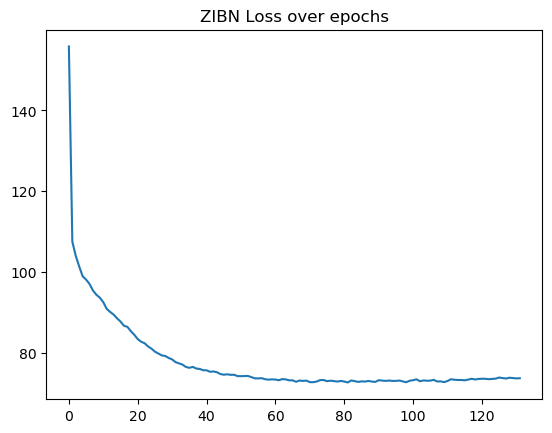

In [10]:
plt.plot(range(0,132),losses_vae_ZINB,'-')
plt.title("ZIBN Loss over epochs")
plt.show()

## Graphic visualization of the Archetypal Analysis

In [ ]:
import phate
import scprep
import matplotlib.pyplot as plt

phate_op = phate.PHATE(n_components=3, knn=10, decay=40, random_state=42)
data_phate = phate_op.fit_transform(NewsGroups.obsm['X_archetypes'])

# Store PHATE coords
NewsGroups.obsm['X_phate_3d'] = data_phate

# We want to color points based on their dominant archetype
# Argmax gives the index (0-7) of the archetype with the highest weight
archetype_labels = np.argmax(NewsGroups.obsm['X_archetypes'], axis=1)

archetype_labels_str = [f"Archetype {i+1}" for i in archetype_labels]

scprep.plot.scatter3d(
    data_phate,
    c=archetype_labels_str,  # Color by dominant archetype
    title=f"3D Archetypal Simplex (k={N_ARCHETYPE})",
    legend_title="Dominant Archetype",
    figsize=(10, 8),
    cmap="tab10",  # Distinct colors for 8 archetypes
    ticks=False,
    label_prefix="PHATE"
)
plt.show()

Calculating PHATE...
  Running PHATE on 11314 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.75 seconds.
    Calculating affinities...
    Calculated affinities in 2.91 seconds.
  Calculated graph and diffusion operator in 3.70 seconds.
  Calculating landmark operator...
    Calculating SVD...


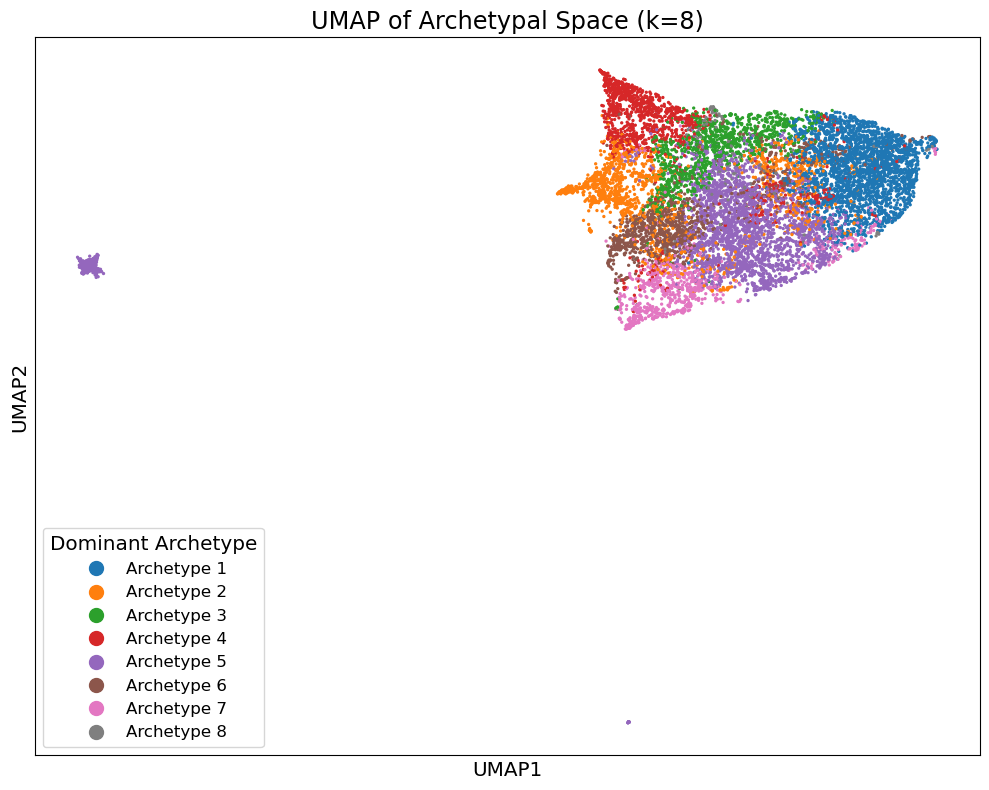

In [48]:
import umap
import numpy as np
import scprep
import matplotlib.pyplot as plt

umap_op = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
data_umap_archetypes = umap_op.fit_transform(NewsGroups.obsm['X_archetypes'])

NewsGroups.obsm['X_umap_archetypes'] = data_umap_archetypes

n_actual_archetypes = NewsGroups.obsm['X_archetypes'].shape[1]
archetype_labels = np.argmax(NewsGroups.obsm['X_archetypes'], axis=1)
archetype_labels_str = [f"Archetype {i+1}" for i in archetype_labels]

ax = scprep.plot.scatter2d(
    data_umap_archetypes,
    c=archetype_labels_str,
    title=f"UMAP of Archetypal Space (k={n_actual_archetypes})",
    legend_title="Dominant Archetype",
    figsize=(10, 8),
    cmap="tab10",
    ticks=False,
    label_prefix="UMAP"
)

purest_indices = [np.argmax(NewsGroups.obsm['X_archetypes'][:, i]) for i in range(n_actual_archetypes)]
purest_coords = data_umap_archetypes[purest_indices]

ax.scatter(
    purest_coords[:, 0], 
    purest_coords[:, 1], 
    s=200, 
    marker='*', 
    c='black', 
    edgecolors='white', 
    label='Archetype Extremas',
    zorder=10
)

for i in range(n_actual_archetypes):
    ax.text(
        purest_coords[i, 0], 
        purest_coords[i, 1], 
        str(i+1), 
        fontsize=12, 
        fontweight='bold', 
        color='white', 
        ha='center', 
        va='center'
    )

plt.show()

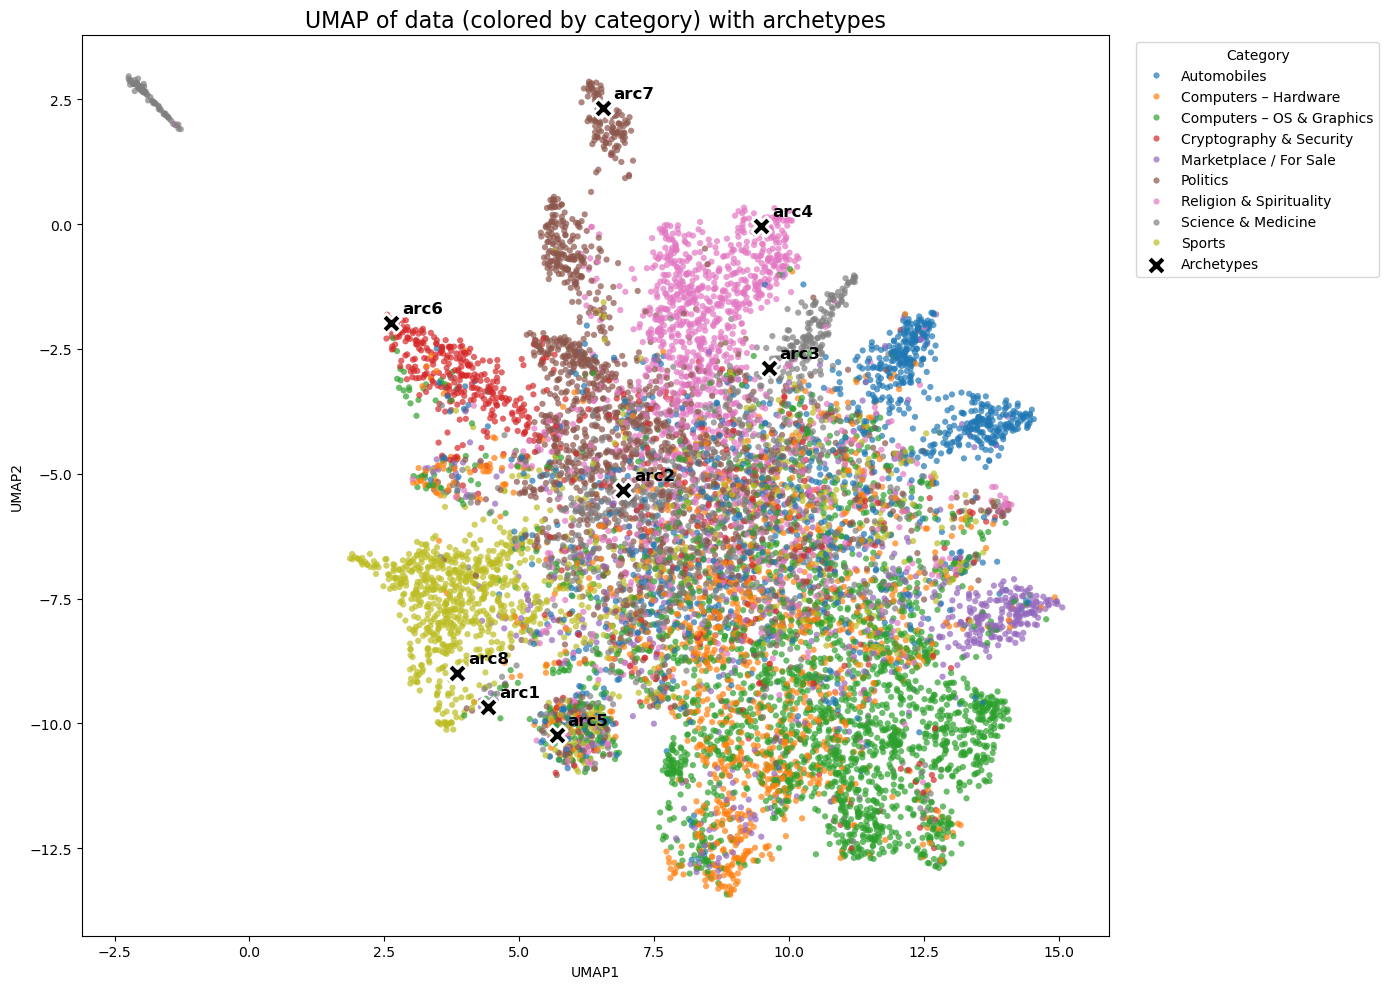

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

umap_coords = NewsGroups.obsm['X_umap']
categories = NewsGroups.obs['category']

df_plot = pd.DataFrame({
    'UMAP1': umap_coords[:, 0],
    'UMAP2': umap_coords[:, 1],
    'Category': categories
})

n_archetypes = NewsGroups.obsm['X_archetypes'].shape[1]
archetype_coords = []

for i in range(n_archetypes):
    # Find index of the document with max weight for Archetype i
    purest_idx = np.argmax(NewsGroups.obsm['X_archetypes'][:, i])
    # Get its UMAP coordinates
    coords = umap_coords[purest_idx]
    archetype_coords.append(coords)

archetype_coords = np.array(archetype_coords)

plt.figure(figsize=(14, 10))

sns.scatterplot(
    data=df_plot,
    x='UMAP1',
    y='UMAP2',
    hue='Category',
    palette='tab10',  
    s=20,              
    alpha=0.7,         
    linewidth=0
)

plt.scatter(
    archetype_coords[:, 0],
    archetype_coords[:, 1],
    marker='X',
    s=200,             
    c='black',         
    linewidths=2,
    edgecolors='white',
    label='Archetypes',
    zorder=10          
)

for i in range(n_archetypes):
    plt.text(
        archetype_coords[i, 0] + 0.2, 
        archetype_coords[i, 1] + 0.2,
        f"arc{i+1}", 
        fontsize=12, 
        fontweight='bold', 
        color='black',
        zorder=11
    )

plt.title("UMAP of data (colored by category) with archetypes", fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Category")
plt.tight_layout()
plt.show()

In [ ]:
import umap
import numpy as np

umap_3d = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1, random_state=42)

# Fit on the original data
X_umap_3d = umap_3d.fit_transform(NewsGroups.X) 

# Save it to the object so we don't lose it
NewsGroups.obsm['X_umap_3d'] = X_umap_3d
print("3D UMAP shape:", NewsGroups.obsm['X_umap_3d'].shape)

Computing 3D UMAP...
3D UMAP shape: (11314, 3)


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

df_3d = pd.DataFrame(
    NewsGroups.obsm['X_umap_3d'], 
    columns=['UMAP1', 'UMAP2', 'UMAP3']
)
df_3d['Category'] = NewsGroups.obs['category'].values

fig = px.scatter_3d(
    df_3d, 
    x='UMAP1', 
    y='UMAP2', 
    z='UMAP3',
    color='Category',
    color_discrete_sequence=px.colors.qualitative.T10, 
    opacity=0.6,
    title="Interactive 3D UMAP with Archetypes"
)

fig.update_traces(marker=dict(size=3))

n_archetypes = NewsGroups.obsm['X_archetypes'].shape[1]

archetype_coords_3d = []
for i in range(n_archetypes):
    purest_idx = np.argmax(NewsGroups.obsm['X_archetypes'][:, i])
    archetype_coords_3d.append(NewsGroups.obsm['X_umap_3d'][purest_idx])
archetype_coords_3d = np.array(archetype_coords_3d)

fig.add_trace(go.Scatter3d(
    x=archetype_coords_3d[:, 0],
    y=archetype_coords_3d[:, 1],
    z=archetype_coords_3d[:, 2],
    mode='markers+text',
    marker=dict(
        size=10, 
        color='black', 
        symbol='x',    
        line=dict(width=2, color='white') 
    ),
    text=[f"<b>Arc {i+1}</b>" for i in range(n_archetypes)], 
    textposition="top center",
    name='Archetypes'
))

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=30),
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    legend_title_text='Category'
)

fig.show(renderer="browser")

NameError: name 'NewsGroups' is not defined

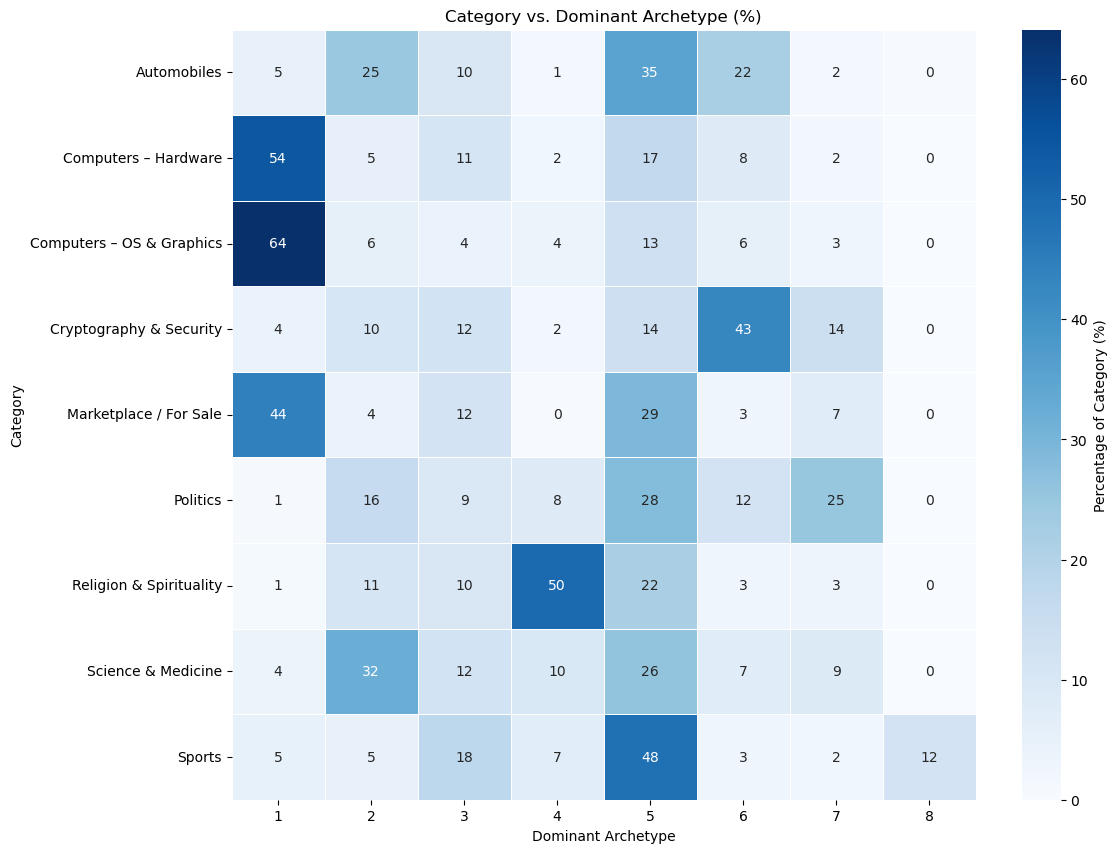

In [ ]:
dominant_arch = np.argmax(NewsGroups.obsm['X_archetypes'], axis=1) + 1 

crosstab = pd.crosstab(
    index=NewsGroups.obs['category'], 
    columns=dominant_arch,
    rownames=['Category'],
    colnames=['Dominant Archetype']
)

crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 10))
sns.heatmap(
    crosstab_pct, 
    annot=True, 
    fmt=".0f",      
    cmap="Blues",
    linewidths=.5,
    cbar_kws={'label': 'Percentage of Category (%)'}
)
plt.title("Category vs. Dominant Archetype (%)")
plt.show()